# Demo of the pywst package

## 0. Presentation of the test maps

* Plot of three real intensity maps
* Plot of one complex polarization map

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
import os
import sys

In [2]:
sys.path.insert(0, os.path.abspath('..'))
import pywst as pw

In [3]:
mapsI = []
mapsI.append (fits.open('data/I_1.fits')[0].data)
mapsI.append (fits.open('data/I_2.fits')[0].data)
mapsI.append (fits.open('data/I_3.fits')[0].data)
mapsI = np.array(mapsI)

mapQiU = fits.open('data/Q_1.fits')[0].data + 1j * fits.open('data/U_1.fits')[0].data

In [4]:
def plot_axis(fig, ax, data, title='', colorbar=True):
    im = ax.imshow (data, cmap='jet', vmin=data.mean()-3*data.std (), vmax=data.mean()+3*data.std())
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plot_axis(fig, axs[0], mapsI[0], "I_1")
plot_axis(fig, axs[1], mapsI[1], "I_2")
plot_axis(fig, axs[2], mapsI[1], "I_3")
plt.show()

<IPython.core.display.Javascript object>

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
plot_axis(fig, axs[0], mapQiU.real, "Q")
plot_axis(fig, axs[1], mapQiU.imag, "U")
plt.show()

<IPython.core.display.Javascript object>

## 1. WST computation

* This section describes how to compute and plot WST of real and complex maps.
* Examples are first given when computing global WST statistics for one map, either real or complex.
* It is then shown how to compute and plot local WST coefficients, as well as WST statistics of several maps.

In [7]:
# We first define the global parameters of the WST transform
M, N = mapsI[0].shape # shapes of the maps on which the transform is applied
J = 7 # Number of dyadic scales of the transform
L = 8 # Number of angles in which the interval [0,pi] is divided
OS = 0 # OverSampling parameter, modifying the output of the transform for local computations
# Values larger than 1 for OS are not recommended without specific knowledge of the WST

### 1.1. One real map, global WST
* Computation of the global WST of a real I intensity map
* Plot of the WST coefficients
* Normalization of the WST coefficients

In [8]:
# We first define the WST operator with the global parameters previously defined
# (this command can take about one minute due to the computation of the bank of filters)
wst_op = pw.WSTOp(M, N, J, L, OS)

In [54]:
# This operator allows to compute the WST of real intensity maps.
wst = wst_op.apply(mapsI[0])

In [55]:
# The output of the operator is an instance of the WST class
type(wst)

pywst.wst.WST

<IPython.core.display.Javascript object>


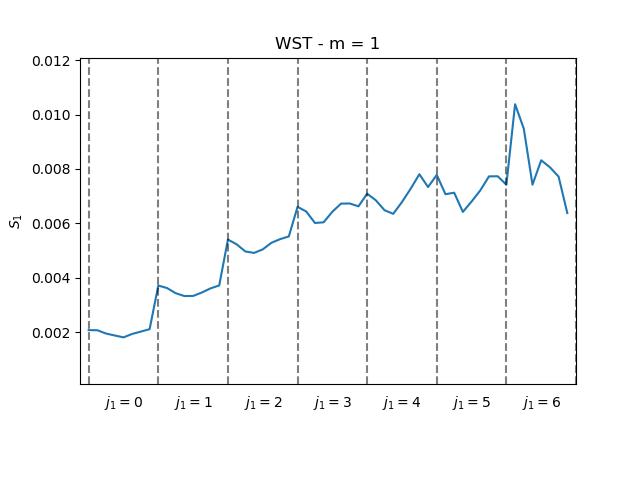

<IPython.core.display.Javascript object>


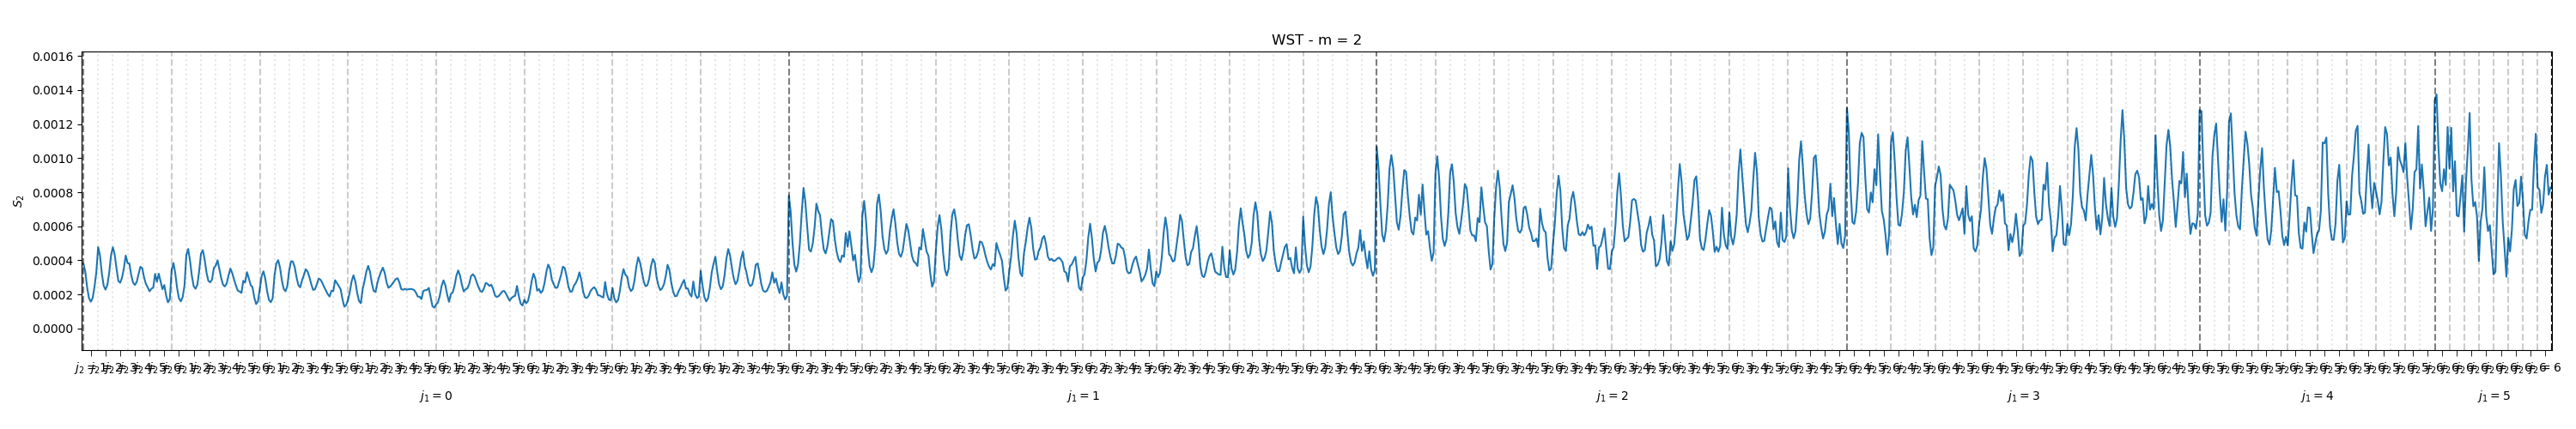

In [56]:
# Both m=1 and m=2 WST coefficients can be plotted by the "plot" method
# The results are given in (j1,theta1) and (j1,theta1,j2,theta2) lexicographical orders
# For instance, the m=1 plot has J different j1 values, for which L angular values are used.
wst.plot()

In [11]:
# The coefficients can also be directly obtained with the "get_coeffs" method
# The layer of coefficient can be selected, as well as values for "j" and "theta"
coeffs, index = wst.get_coeffs(layer=1, j1=2)
print(coeffs)

[0.00540639 0.00523131 0.00496854 0.00491487 0.00504498 0.00528845
 0.00542174 0.00552155]


In [57]:
# The indices of the different coefficients are also given
# They are in an array with 5 row which respectively give:
# m, j1, theta1, j2, theta2
print(index.shape)
print(index)

(5, 8)
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2.]
 [0. 1. 2. 3. 4. 5. 6. 7.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


<IPython.core.display.Javascript object>


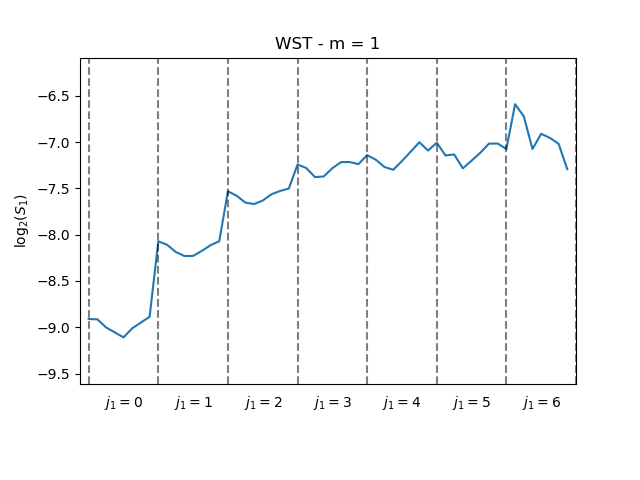

In [58]:
# It is usually more convenient to save and plot the logarithmic values of the coefficients
# We use a base 2 logarithm to be consistent with the diadic scales used
# It can be done using the "to_log2()" method
wst.to_log2()
wst.plot(layer=1)

[-3.1542283]


<IPython.core.display.Javascript object>


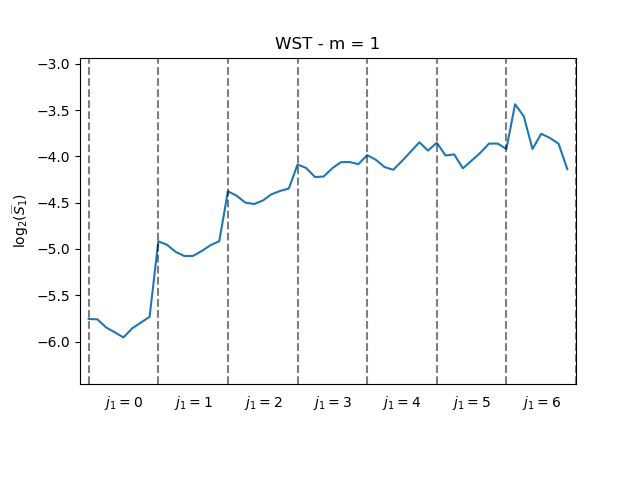

In [59]:
# The WST coefficients can also be normalized
# The m=1 layer is normalized by the m=0 one, and the m=2 by the m=1
wst.normalize()
mean, _ = wst.get_coeffs(layer=0)
print(mean)
wst.plot(layer=1)

In [60]:
# More details can be obained with the help command
help(wst.normalize)

Help on method normalize in module pywst.wst:

normalize() method of pywst.wst.WST instance
    Normalization of the coefficients.
    
    Layer 0 coefficients are left unchanged.
    Layer 1 coefficients are normalized by layer 0 coefficients (locally if available):
        
    .. math::
        
        \bar{S}_1(j_1,\theta_1) = S_1(j_1,\theta_1)/S_0
        
    Layer 2 coefficients are normalized by the corresponding layer 1 coefficients (locally if available):
        
    .. math::
        
        \bar{S}_2(j_1,\theta_1,j_2,\theta_2) = S_2(j_1,\theta_1,j_2,\theta_2)/S_1(j_1,\theta_1)
    
    Returns
    -------
    None.



In [61]:
# We can check the normalization and log2 status of the coefficients as follows:
print(wst.normalized, wst.log2vals)

True True


### 1.2. One complex map, global WST
* Computation of the global WST of a complex Q+iU polarization map
* Plot of the normalized WST coefficients

In [16]:
# We first define the WST operator for complex map (can also take about one minute)
# We apply it to a complex Q+iU polarized map
# We then plot the log normalized m=1 coefficients
# Note that those coefficients have 2L theta1 values, since angles in [0,2pi] are considered
wst_op_cplx = pw.WSTOp(M, N, J, L, OS, cplx=True)
wst_cplx = wst_op_cplx.apply(mapQiU)
wst_cplx.to_log2()
wst_cplx.normalize()
wst_cplx.plot(layer=1)

<IPython.core.display.Javascript object>

### 1.3. One real map, local WST
* Computation of the local WST of a real intensity map
* Management of the boundary issues by cropping
* Averaging of the local coefficients

<IPython.core.display.Javascript object>


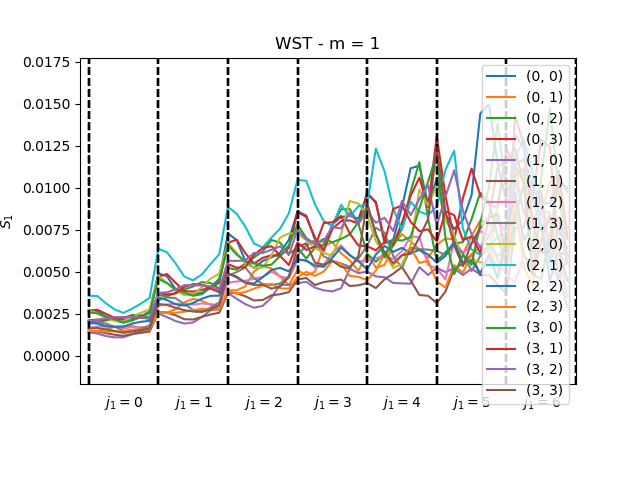

In [62]:
# The previous WST operator for real maps allows for local WST computations
# We perform this transform and plot the local coefficients
wst = wst_op.apply(mapsI[0], local=True)
wst.plot(layer=1)

# Note than when a local WST transform is computed, the output of the transform is obtained
# by performing a subsampling at a 2^{J-OS} scale per axis. For the present exemple, the size 
# of the maps is 2^9 x 2^9, J=7, and OS=0. Therefore, the spatial shape of the output is 4x4.
# Thus, 16 local WST transforms are given in the present example.

<IPython.core.display.Javascript object>


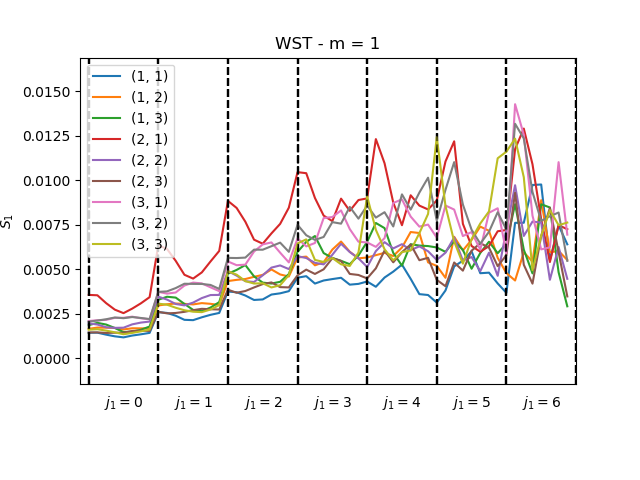

In [63]:
# When working with maps for which periodic boundary conditions are irrelevant, as 
# from observational data, it is necessary to remove the local WST coefficient close 
# to the boundaries. Indeed, the wavelet transform in PyWST are implemented under PBC 
# assumption. In PyWST, this is done by cropping the local WST obtained.
wst = wst_op.apply(mapsI[0], local=True, crop=1)
wst.plot(layer=1)

# This option boils down to removing a band of 2*(crop-1)*2^J pixels in the initial maps, 
# which translates in a band of 2*(crop-1)*2^OS for the local resolution of the WST. 
# This band is centered on the boundary of the maps, which mean that when crop=1, 2^(J-1) are
# removed on each boundary.
# When working with OS != 0, it is possible to choose non-integer values for crop, which can be
# multiples of 0.5 if OS=1

# EA : See working example 1.5
# EA : Ecrire proprement le descriptif ci-dessus

<IPython.core.display.Javascript object>


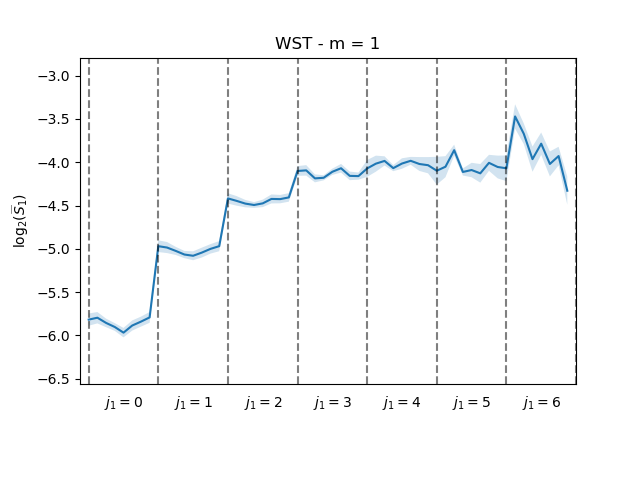

In [64]:
# It it possible to average the local WST coefficients to get global ones.
# This is done by the "average" method, here for the log normalized coefficients.
# Such a computation allows to estimate the errorbars of the WST coefficients
wst.to_log2()
wst.normalize()
wst.average()
wst.plot(layer=1)

In [20]:
# EA : On peut récupérer les erreurs en numpy ?
# EA : Rajouter coeff_std

In [21]:
# EA : ré-écrire pour ce qui se passe pour les erreurs
wst.to_linear()


/Users/berlioz/Allys/ScatnetSoft/PyWST/pywst/pywst/wst.py:234: UserWarning: Warning! The covariance matrix has already been computed with logarithmic coefficients. We compute linear errors from diagonal coefficients and discard off-diagonal coefficients.
  warnings.warn("Warning! The covariance matrix has already been computed with logarithmic coefficients. We compute linear errors from diagonal coefficients and discard off-diagonal coefficients.")


### 1.4. Multiple real maps, global WST
* Computation of the global WST of a batch of real intensity maps

<IPython.core.display.Javascript object>


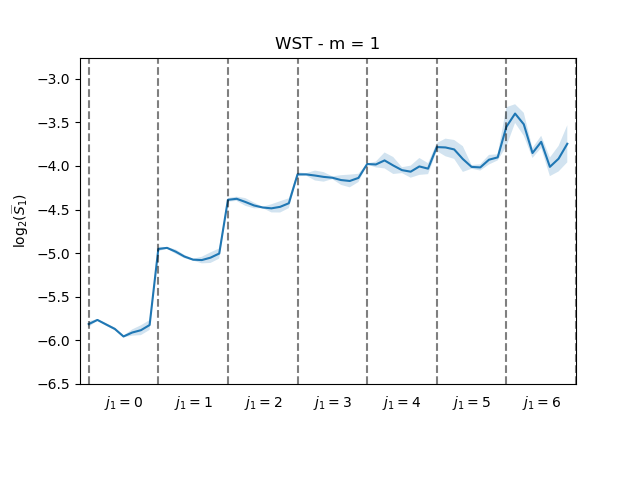

In [48]:
# The previous WST operator can also be applied to a batch of WST maps
# Here we average the results obtained
wst_batch = wst_op.apply(mapsI)
wst_batch.to_log2()
wst_batch.normalize()
wst_batch.average()
wst_batch.plot(layer=1)

# Give details on batch use and local use

### 1.4. Working example for a local analysis
* prout

# 2. RSWT computation


* This section describes how to compute and plot RWST coefficients
* This can be done from maps, or from WST coefficients
* We also show how to change of RWST model

###  2.1. RWST computation from a real intensity map
* Computation of global RWST from a real intensity map

In [49]:
# We first define the RWST operator
# We then apply it to a real intensity map
rwst_op = pw.RWSTOp(M, N, J, L, OS)
rwst = rwst_op.apply(mapsI[0])

# EA : Enlever le warning ici
# EA : voir pour les logs, je suis plutôt ok, mais il faudrait pouvoir les désactiver

/Users/berlioz/Allys/ScatnetSoft/PyWST/pywst/pywst/wst.py:373: UserWarning: Warning! Covariance matrix is None.
  warnings.warn("Warning! Covariance matrix is None.")


In [52]:
# The different terms of the RWST can be displayed
print(rwst.model)

Model: RWSTModel1
--> Layer 0 coefficient: S0
--> Layer 1 coefficients: S1Iso - S1Aniso - ThetaRef1
--> Layer 2 coefficients: S2Iso1 - S2Iso2 - S2Aniso1 - S2Aniso2 - ThetaRef2


<IPython.core.display.Javascript object>


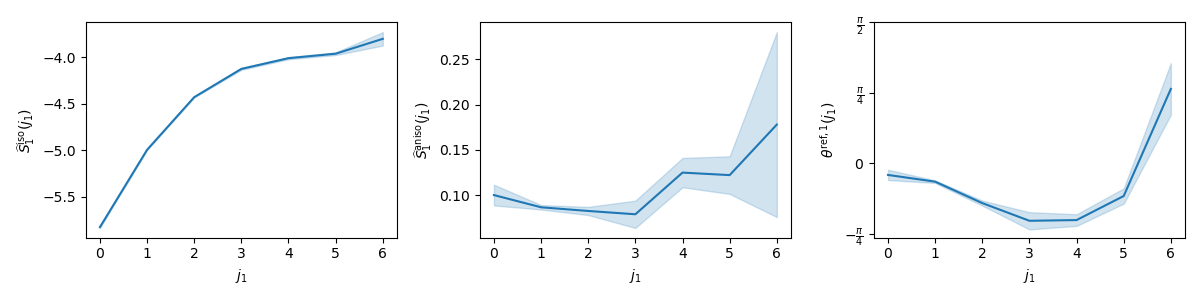

In [53]:
# Plot of the first layer of terms
# These coefficients are given as a function of "j1"
rwst.plot(["S1Iso", "S1Aniso", "ThetaRef1"])

In [26]:
# Get a subset of RWST coefficients
# The coefficients are given for each value of j1 in ascending order
print(rwst.get_coeffs("S1Iso"))

# EA : Mettre un exemple de get_coeffs_std

[-5.82568189 -4.9938135  -4.42738909 -4.12299329 -4.00765812 -3.95939348
 -3.79954237]


###  2.2. RWST computation from a batch of maps
* Computation of global RWST from a batch of global intensity maps

In [27]:
# The same operator can be applied to a batch of map
rwst_batch = rwst_op.apply(mapsI)

# EA : Parler des erreurs ? Du coup calculées comment ici ?

In [28]:
# Plot of some second-layer terms
# Each curve corresponds to a given value of "j1" for all "j2>j1"
print(rwst.model)
rwst.plot(["S2Iso1", "S2Iso2"])

Model: RWSTModel1
--> Layer 0 coefficient: S0
--> Layer 1 coefficients: S1Iso - S1Aniso - ThetaRef1
--> Layer 2 coefficients: S2Iso1 - S2Iso2 - S2Aniso1 - S2Aniso2 - ThetaRef2


<IPython.core.display.Javascript object>

In [29]:
# Get a subset of RWST coefficients
# The coefficients are given in a matrix with entries ("j1","j2")
# All coefficients that don't verify "j2>j1" have zero value
print(rwst.get_coeffs("S2Iso1"))

[[ 0.         -3.12410518 -2.7346727  -2.65211004 -2.81373518 -3.07693623
  -3.26555409]
 [ 0.          0.         -2.94031675 -2.71243468 -2.81887533 -3.09080908
  -3.29349422]
 [ 0.          0.          0.         -2.95305676 -2.87501808 -3.114345
  -3.34900468]
 [ 0.          0.          0.          0.         -3.00521014 -3.04362102
  -3.34541397]
 [ 0.          0.          0.          0.          0.         -3.11842614
  -3.24268684]
 [ 0.          0.          0.          0.          0.          0.
  -3.28332506]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]]


###  2.3. RWST computation from WST coefficients
* Computation of global RWST from a batch of global WST of a real intensity map

In [30]:
# The same operator can be applied to a batch of map
rwst_batch = rwst_op.apply(wst_batch)

# Dire que c'est possible de prendre en compte la matrice de covariance complète avec diag_cov=False

In [31]:
print(rwst_batch.model)

Model: RWSTModel1
--> Layer 0 coefficient: S0
--> Layer 1 coefficients: S1Iso - S1Aniso - ThetaRef1
--> Layer 2 coefficients: S2Iso1 - S2Iso2 - S2Aniso1 - S2Aniso2 - ThetaRef2


In [32]:
print(rwst_batch.get_coeffs("S1Iso"))

# It is possible to plot all the RWST coefficient with the "plot" method
rwst_batch.plot()

[-5.86352426 -5.01216871 -4.43292258 -4.12208355 -4.01214952 -3.90415916
 -3.70847034]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2.2. RWST computation from maps
* Computation of local RWST forom a real intensity map

In [33]:
# The RWST operator previously defined can directly be applied to maps instead of WST coefficients
# Here we compute local RWST coefficients
rwst = rwst_op.apply(mapsI[0], local=True, crop=1.0)

/Users/berlioz/Allys/ScatnetSoft/PyWST/pywst/pywst/wst.py:373: UserWarning: Warning! Covariance matrix is None.
  warnings.warn("Warning! Covariance matrix is None.")


In [34]:
# For each RWST layer, we can get the name of the different terms
print(rwst.model.layer1_names)

['S1Iso', 'S1Aniso', 'ThetaRef1']


In [35]:
# We can then get the coefficients of each RWST terms
print(rwst.get_coeffs("S0")[0])

# Expliquer ce que signifient les tirets.

# EA : ici c'est pas très clair comment les coefficients sont indiqués
# EA : Que sont ces différents tirets ? 
# EA : Ce serait peu-être mieux de mettre cet exemple plus haut, ou alors de ne sélectionner ici
# qu'un seul des coefficients locaux

[[-- -- -- --]
 [-- -3.5577657789284522 -3.386826179990313 -3.226062419053642]
 [-- -2.8019615185024573 -3.344225473285801 -3.4243128394281497]
 [-- -3.001627150878994 -2.9133417994535513 -3.3715772196295695]]


In [36]:
# We can also plot certain RWST terms
rwst.plot(["S1Iso", "S1Aniso"])

<IPython.core.display.Javascript object>

### 2.3. Changing the RWST model
* Change model
* Full plot
* Defining your own model

In [37]:
rwst_op_model2 = pw.RWSTOp(M, N, J, L, wst_op=wst_op, model_cls=pw.RWSTModel2)
rwst = rwst_op_model2.apply(mapsI[0], local=True, crop=1.0)
print(rwst.model.layer1_names)

/Users/berlioz/Allys/ScatnetSoft/PyWST/pywst/pywst/wst.py:373: UserWarning: Warning! Covariance matrix is None.
  warnings.warn("Warning! Covariance matrix is None.")


['S1Iso', 'S1Aniso', 'ThetaRef1', 'S1Lat1', 'S1Lat2']


In [38]:
rwst.plot(['S1Lat1', 'S1Lat2'])

<IPython.core.display.Javascript object>

## 3. Comparison of (R)WST statistics

* Comparison of WST and its corresponding RWST model

* Comparison between RWSTs

In [39]:
wst_batch.plot_compare(rwst_batch, layer=1, labels=['samples', 'model'])

<IPython.core.display.Javascript object>

In [40]:
rwst_1 = rwst_op.apply(mapsI[0])
rwst_2 = rwst_op.apply(mapsI[1])
rwst_3 = rwst_op.apply(mapsI[2])

rwst_1.plot_compare([rwst_2, rwst_3], "S1Iso", labels=["rwst_1", "rwst_2", "rwst_3"])

/Users/berlioz/Allys/ScatnetSoft/PyWST/pywst/pywst/wst.py:373: UserWarning: Warning! Covariance matrix is None.
  warnings.warn("Warning! Covariance matrix is None.")


KeyboardInterrupt: 

## 4. Playing with filters

* Unit $L^1$-norm

In [ ]:
def plot_filter(data):
    data = np.fft.fftshift(data) # Centering of the filter
    fig, axs = plt.subplots(1, 2, figsize=(10,3))
    plot_axis(fig, axs[0], data.real, "Real part")
    plot_axis(fig, axs[1], data.imag, "Imaginary part")
    plt.show()

### 4.1. Gaussian filters

In [ ]:
gaussian = pw.GaussianFilter(M, N, 5, gamma=0.3)
print ("Mean:", gaussian.data.mean(), "\nL1-norm:", np.sum(np.absolute(gaussian.data)))
plot_filter(gaussian.data)

### 4.2. Morlet wavelets

In [ ]:
morlet = pw.MorletWavelet(M, N, 6, np.pi/4, 0.5, sigma0=0.8, k0=3*np.pi/4)
print("Mean:", morlet.data.mean(), "\nL1-norm:", np.sum(np.absolute(morlet.data)))
plot_filter(morlet.data)

### 4.3. Top-hat filters

In [ ]:
tophat = pw.TopHatFilter(M, N, 5, gamma=0.3)
print ("Mean:", tophat.data.mean(), "\nL1-norm:", np.sum(np.absolute(tophat.data)))
plot_filter(tophat.data)

### 4.4. Changing filters for your WST operator

In [ ]:
#wst_op = pw.WSTOp(M, N, J, L, OS, lp_filter_cls=pw.GaussianFilter, bp_filter_cls=pw.MorletWavelet)